# Can money save us? An analysis of suicide rates in the context of changing economic prosperity.

In [714]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram


In [1016]:
suicide_data = pd.read_csv('data/master.csv')
suicide_data.head(2)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent


In [1017]:
suicide_data.shape

(27820, 12)

In [1018]:
suicide_data.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object

In [1019]:
# looking at missing data
suicide_data.isna().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [1020]:
# unique countries
len(pd.unique(suicide_data["country"]))

101

In [1021]:
# number of years`
len(pd.unique(suicide_data["year"]))

32

In [1022]:
min(suicide_data['year'])

1985

In [1023]:
max(suicide_data['year'])

2016

In [1024]:
# grouping to analyze how complete the dataset is 
agg_dict = {'country':'nunique', 'age':'nunique',
            'population':'mean',
            'suicides_no':'sum',
            'suicides/100k pop':'mean'}


suicides_by_year = suicide_data[['year', 'country','age', 'population','suicides_no',
                                 'suicides/100k pop']].groupby('year').agg(agg_dict)
suicides_by_year.head()

,country,age,population,suicides_no,suicides/100k pop
year,,,,,
1985,48,6,1.751042e+06,116063,11.826198
1986,48,6,1.788038e+06,120670,11.423333
1987,54,6,1.689861e+06,126842,11.644213
1988,49,6,1.792678e+06,121026,12.709405
1989,52,6,1.963965e+06,160244,12.879071


In [1025]:
suicides_by_year.query('year < 1988 | year > 2013')

,country,age,population,suicides_no,suicides/100k pop
year,,,,,
1985,48,6,1.751042e+06,116063,11.826198
1986,48,6,1.788038e+06,120670,11.423333
1987,54,6,1.689861e+06,126842,11.644213
2014,78,6,2.042796e+06,222984,11.011464
2015,62,6,2.385293e+06,203640,11.094073
2016,16,5,8.256368e+05,15603,13.421188


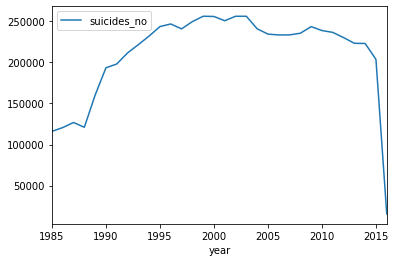

In [1026]:
across_years = pd.DataFrame(suicide_data.groupby('year')['suicides_no'].sum())
across_years.plot()

Because the year 2016 only has 16 countries and much lower suicide rates compared to previous years, this year will be dropped from the analysis as it clearly has icomplete data and would result in bias. I verified via graph that there is a sharp drop as well. 

In [1027]:
clean_data = suicide_data.query('year < 2016')

In [1028]:
# suicide ratio trend
by_year_clean = suicides_by_year.query('year < 2016')
by_year_clean.reset_index(inplace=True)

Text(0.5, 1.0, 'Suicides/100k of Population Across Time')

<Figure size 1440x2160 with 0 Axes>

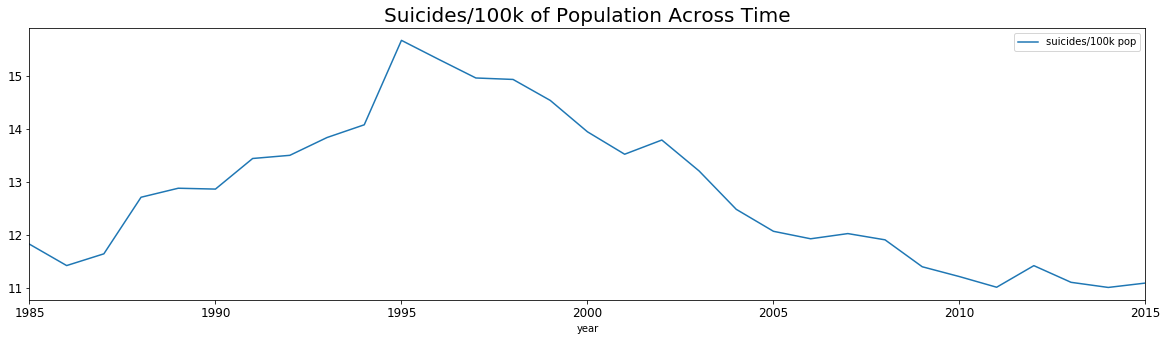

In [1029]:
plt.figure(figsize = (20,30))
by_year_clean.plot(kind='line', x='year', y='suicides/100k pop', figsize=(20,5), fontsize=12)
plt.title(label = "Suicides/100k of Population Across Time", fontdict = {"fontsize": 20, "fontweight": 'normal' })

In [591]:
# cumulative rate of suicides across countries 
country_data = clean_data.groupby(['country']).sum()
country_sorted = country_data[['suicides_no']].sort_values(by='suicides_no', ascending=False)
country_sorted.head(5)

,suicides_no
country,
Russian Federation,1209742
United States,1034013
Japan,806902
France,329127
Ukraine,319950


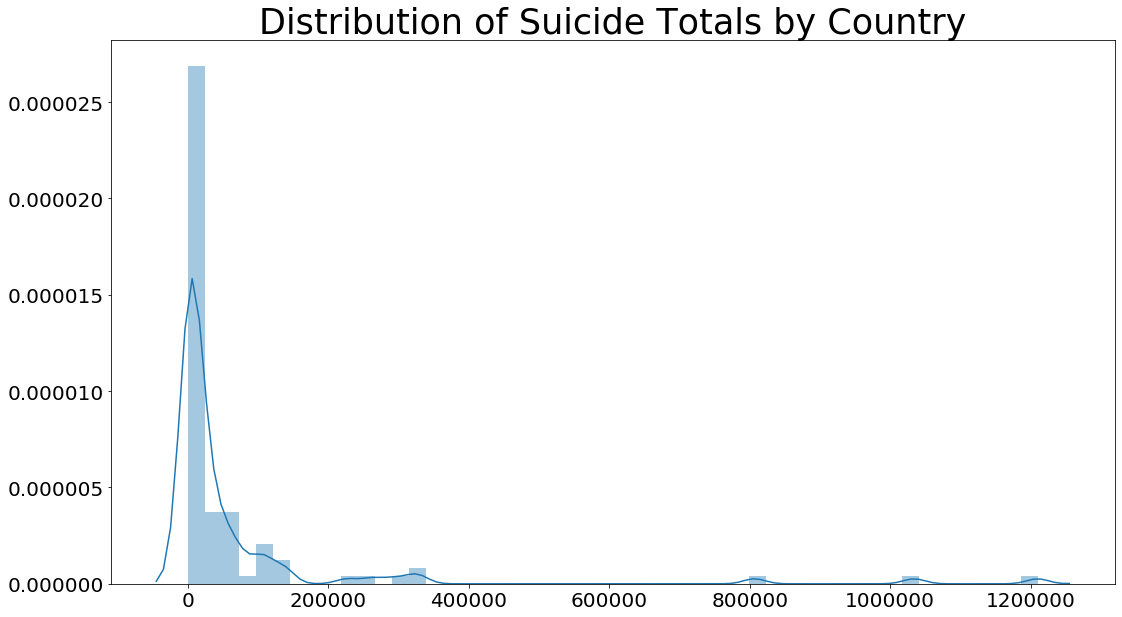

In [592]:
# visualizing distribition of overall suicides across countries 
plt.figure(figsize=(18,10))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title("Distribution of Suicide Totals by Country", fontsize=35)
sns.distplot(country_sorted)

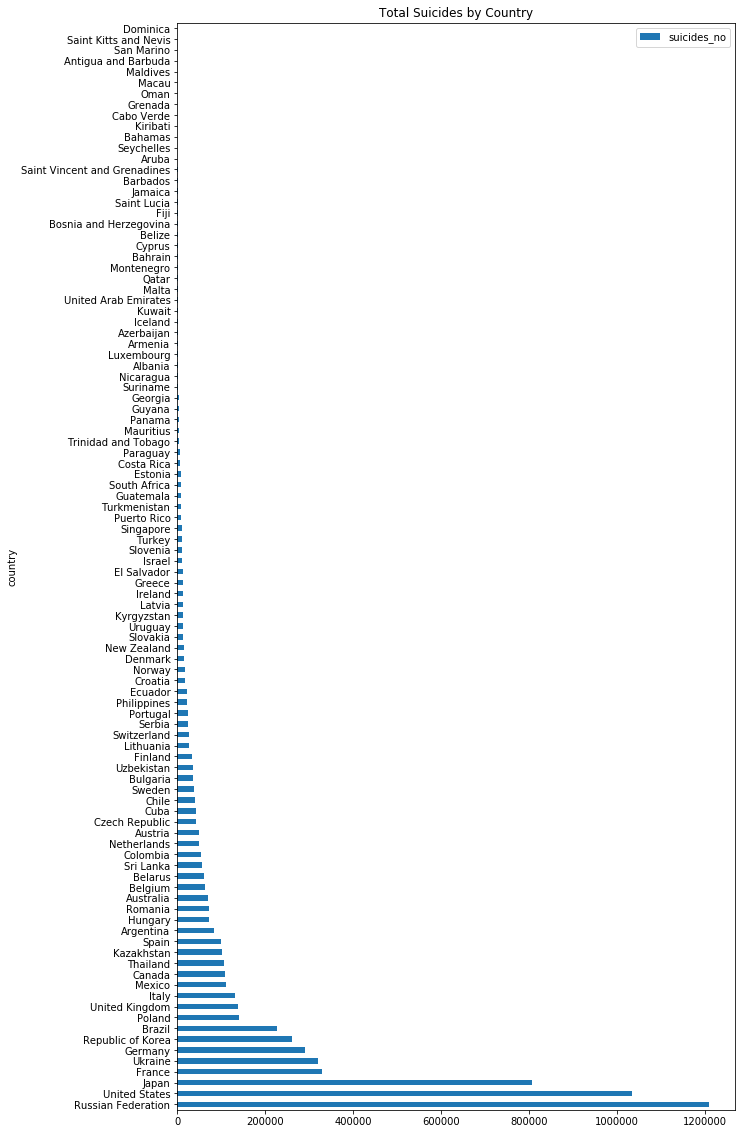

In [891]:
country_sorted.plot(kind='barh', title="Total Suicides by Country", figsize=(10,20))

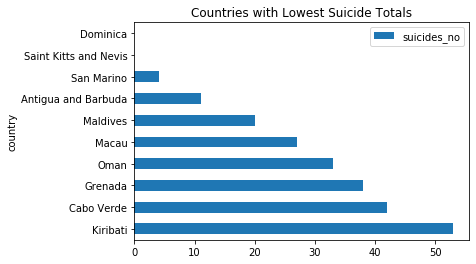

In [595]:
country_sorted.tail(10).plot(kind='barh',title="Countries with Lowest Suicide Totals" )

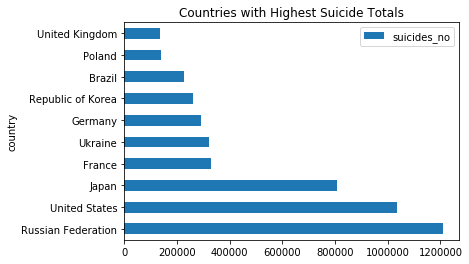

In [596]:
# top 10 vs. bottom 10 
country_sorted.head(10).plot(kind='barh', title="Countries with Highest Suicide Totals")

In [181]:
# creating filters
top_10 = ['United Kingdom' , 'Poland', 'Brazil', 'Republic of Korea', 'Germany', 
         'Ukraine', 'France', 'Japan', 'United States', 'Russian Federation']
bottom_10 = ['Dominica', 'Saint Kitts and Nevis', 'San Marino', 'Antigue and Barbuda', 
            'Maldives', 'Macau', 'Oman', 'Grenada', 'Cabo Verde', 'Kiribati']

In [509]:
# sucicide distributions of top 10 countries
country_year = clean_data.groupby(['country', 'year']).sum().reset_index()
country_year_top10 = country_year[country_year['country'].isin(top_10)]

In [511]:
country_year_top10.tail()

,country,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
2250,United States,2011,39508,290313825,162.36,10.932,641424
2251,United States,2012,40596,292827128,165.14,10.944,662040
2252,United States,2013,41143,295322862,166.67,10.956,678240
2253,United States,2014,42769,297749735,171.33,10.980,702372
2254,United States,2015,44189,300078511,175.41,0.000,724644


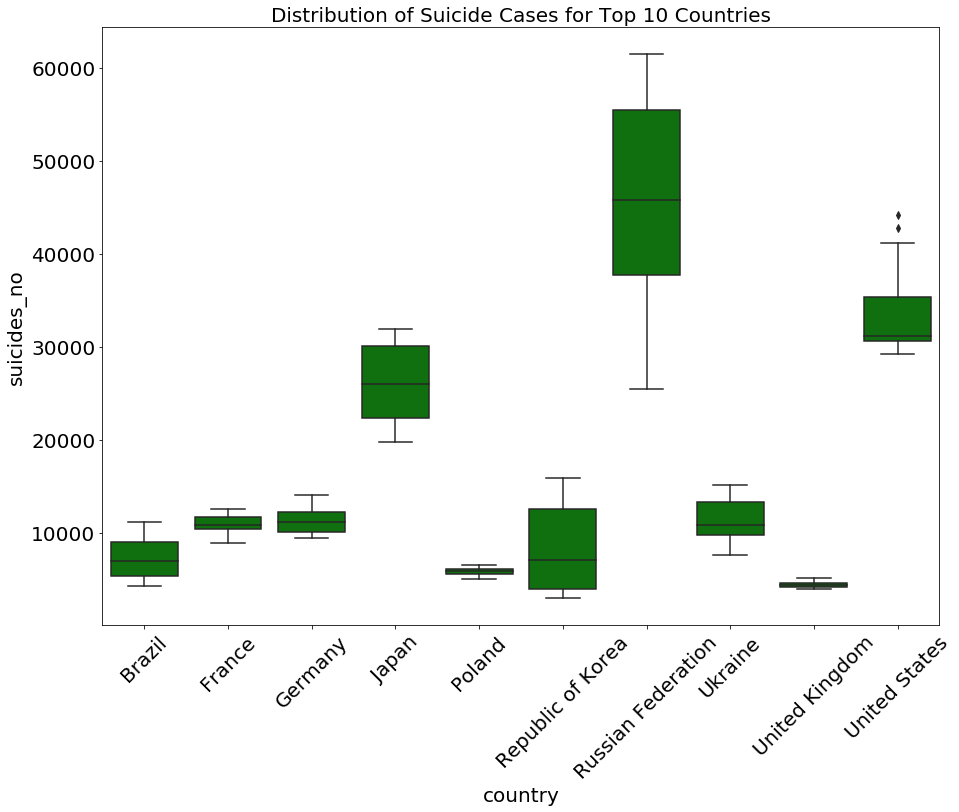

In [601]:
plt.figure(figsize=(15,11))
plt.title("Distribution of Suicide Cases for Top 10 Countries", fontsize=20)
plt.xticks(fontsize=20, rotation = 45)
plt.yticks(fontsize=20)
plt.ylabel('Suicides',size=20)
plt.xlabel('Country',size=20)
sns.boxplot(data=country_year_top10, x='country', y='suicides_no', color='green')

In [514]:
# distributions in bottom 10
# sucicide distributions of top 10 countries
country_year_bottom10 = country_year[country_year['country'].isin(bottom_10)]

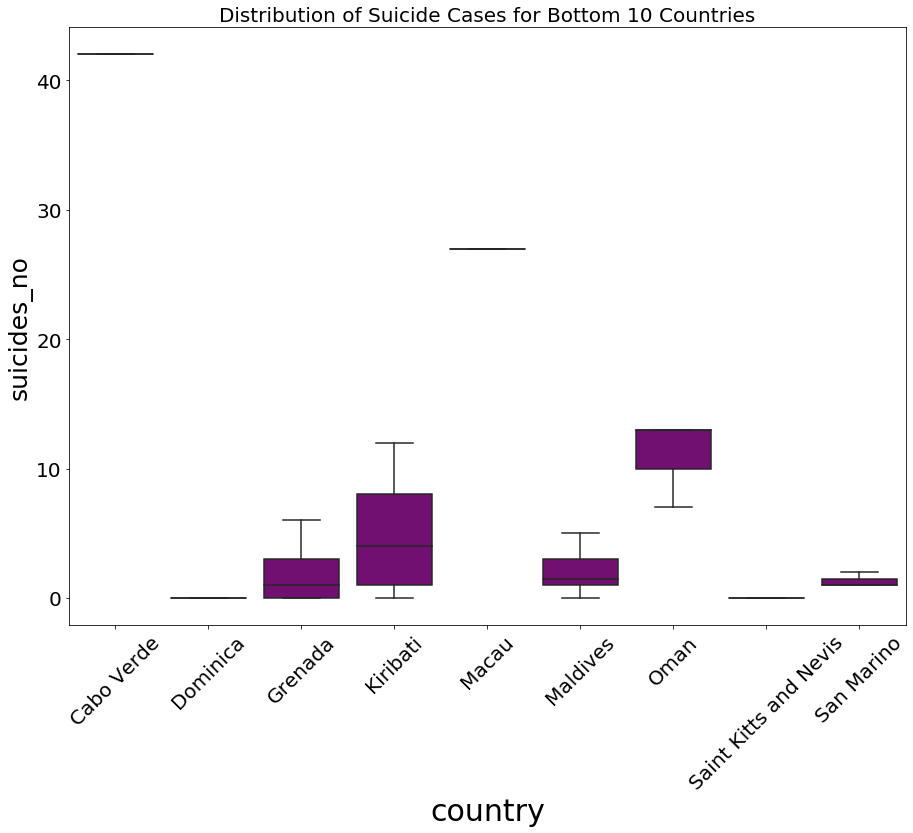

In [602]:
plt.figure(figsize=(15,11))
plt.title("Distribution of Suicide Cases for Bottom 10 Countries", fontsize=20)
plt.xticks(fontsize=20, rotation = 45)
plt.yticks(fontsize=20)
plt.ylabel('Suicides',size=25)
plt.xlabel('Country',size=30)
sns.boxplot(data=country_year_bottom10, x='country', y='suicides_no', color='purple')

In [516]:
# looking at totals by generation
by_generation = clean_data.groupby('generation').sum()[['suicides_no']]
by_generation.head()

,suicides_no
generation,
Boomers,2279783
G.I. Generation,510009
Generation X,1527038
Generation Z,15906
Millenials,620194


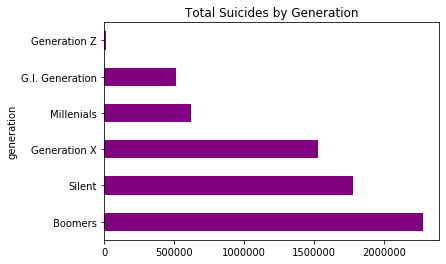

In [517]:
by_generation['suicides_no'].sort_values(ascending=False).plot(kind='barh'
, title="Total Suicides by Generation", color='purple')

In [518]:
# looking at totals by sex
by_sex = clean_data.groupby('sex').sum()[['suicides_no']]

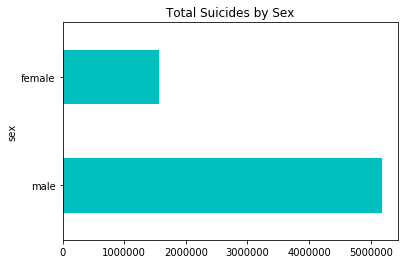

In [519]:
by_sex['suicides_no'].sort_values(ascending=False).plot(kind='barh'
, title="Total Suicides by Sex", color='c')

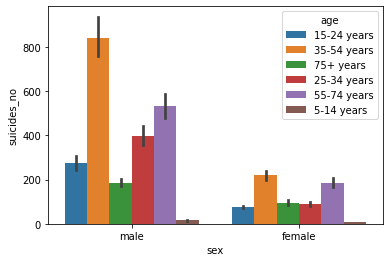

In [599]:
# looking at age groups along sex dimension 
p = sns.barplot(x='sex', y='suicides_no', hue='age', data=clean_data)



In [520]:
# getting statistics
clean_data.groupby('sex')['suicides_no'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,13830.0,112.509472,334.378143,0.0,1.0,14.0,73.0,4053.0
male,13830.0,374.317498,1220.729784,0.0,4.0,48.0,235.0,22338.0


In [521]:
clean_data.groupby('generation')['suicides_no'].describe()

,count,mean,std,min,25%,50%,75%,max
generation,,,,,,,,
Boomers,4958.0,459.819080,1513.006576,0.0,10.0,72.0,297.00,22338.0
G.I. Generation,2744.0,185.863338,519.581015,0.0,2.0,23.0,124.00,6401.0
Generation X,6376.0,239.497804,805.351910,0.0,5.0,34.0,138.00,11767.0
Generation Z,1470.0,10.820408,26.021939,0.0,0.0,2.0,8.75,277.0
Millenials,5780.0,107.300000,425.973365,0.0,1.0,9.0,54.00,6945.0
Silent,6332.0,281.093967,881.415529,0.0,3.0,36.0,177.00,12517.0


In [522]:
country_data[['suicides_no']].describe().unstack()

suicides_no  count    1.000000e+02
             mean     6.732817e+04
             std      1.829568e+05
             min      0.000000e+00
             25%      6.127500e+02
             50%      1.148850e+04
             75%      4.889075e+04
             max      1.209742e+06
dtype: float64

In [582]:
# rate of suicides per 100K population of suicides across countries 
country_data = clean_data.groupby(['country']).sum()
country_rate_sorted = country_data[['suicides/100k pop']].sort_values(by='suicides/100k pop', ascending=False)
country_sorted.head(5)

,suicides/100k pop
country,
Russian Federation,11305.13
Lithuania,10227.16
Hungary,9914.73
Kazakhstan,9519.52
Republic of Korea,9350.45


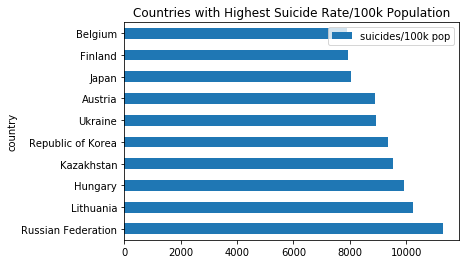

In [586]:
# visualizing top ten countries 
country_rate_sorted.head(10).plot(kind='barh', title="Countries with Highest Suicide Rate/100k Population")

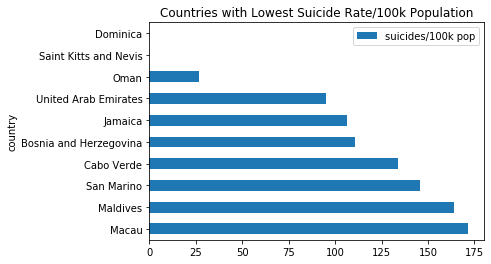

In [584]:
# visualizing botton ten countries 
country_rate_sorted.tail(10).plot(kind='barh', title="Countries with Lowest Suicide Rate/100k Population")

Q1**How do suicide rates differ across countries, generations, and gender? **
Here I hope to look at the cumulative rate of suicide across all years by country (then generation/gender), ranking form highest to lowest. I think visualizing this total with a histogram will be most effective. I would also like to look at the top 10 countries with highest suicide rates in terms of the distribution (violin plots). I am also interested in understanding some summary statistics and overall distributions. For the summary statistics, I'd like to again use the aggregate suicide figure and get the mean, median, minimum, maximum per country/generation/gender. Use Seaborn/Matplotlib

**Q2** How do suicide rates change by year? 
Instead of aggregating across all years, I will instead aggregate at the year level (so group by year) and visualize distributions of suicides across years. I would like to use pairplots as well to look at how the distribution of suicide rates aggregated at the year level changes with respect to other variables in the dataset, as this will allow me to gain some insights into which variables might be good to further test for with regression. Last but not least, I will calculate summary statistics (min/max/median/etc.)
seaborn/matplotlib

In [523]:
# Aggregated suicides across years
across_years = pd.DataFrame(clean_data.groupby('year')['suicides_no'].sum())

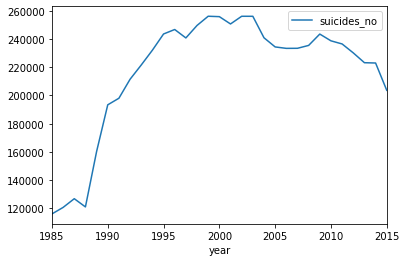

In [524]:
across_years.plot()

In [308]:
across_years.sort_values(by='suicides_no', ascending=False).head(5)

,suicides_no
year,
1999,256119
2002,256095
2003,256079
2000,255832
2001,250652


In [865]:
# creating pivot for generations across years
generation_pivot = clean_data.pivot_table(index='year', columns='generation', values='suicides_no', aggfunc=np.sum)


In [866]:
generation_pivot.fillna(value = 0, inplace=True)
generation_pivot.head()

generation,Boomers,G.I. Generation,Generation X,Generation Z,Millenials,Silent
year,,,,,,
1985,20771.0,40690.0,18854.0,0.0,0.0,35748.0
1986,21685.0,42420.0,19007.0,0.0,0.0,37558.0
1987,22309.0,46517.0,17367.0,0.0,0.0,40649.0
1988,21332.0,44750.0,16174.0,0.0,0.0,38770.0
1989,29427.0,57490.0,19786.0,0.0,0.0,53541.0


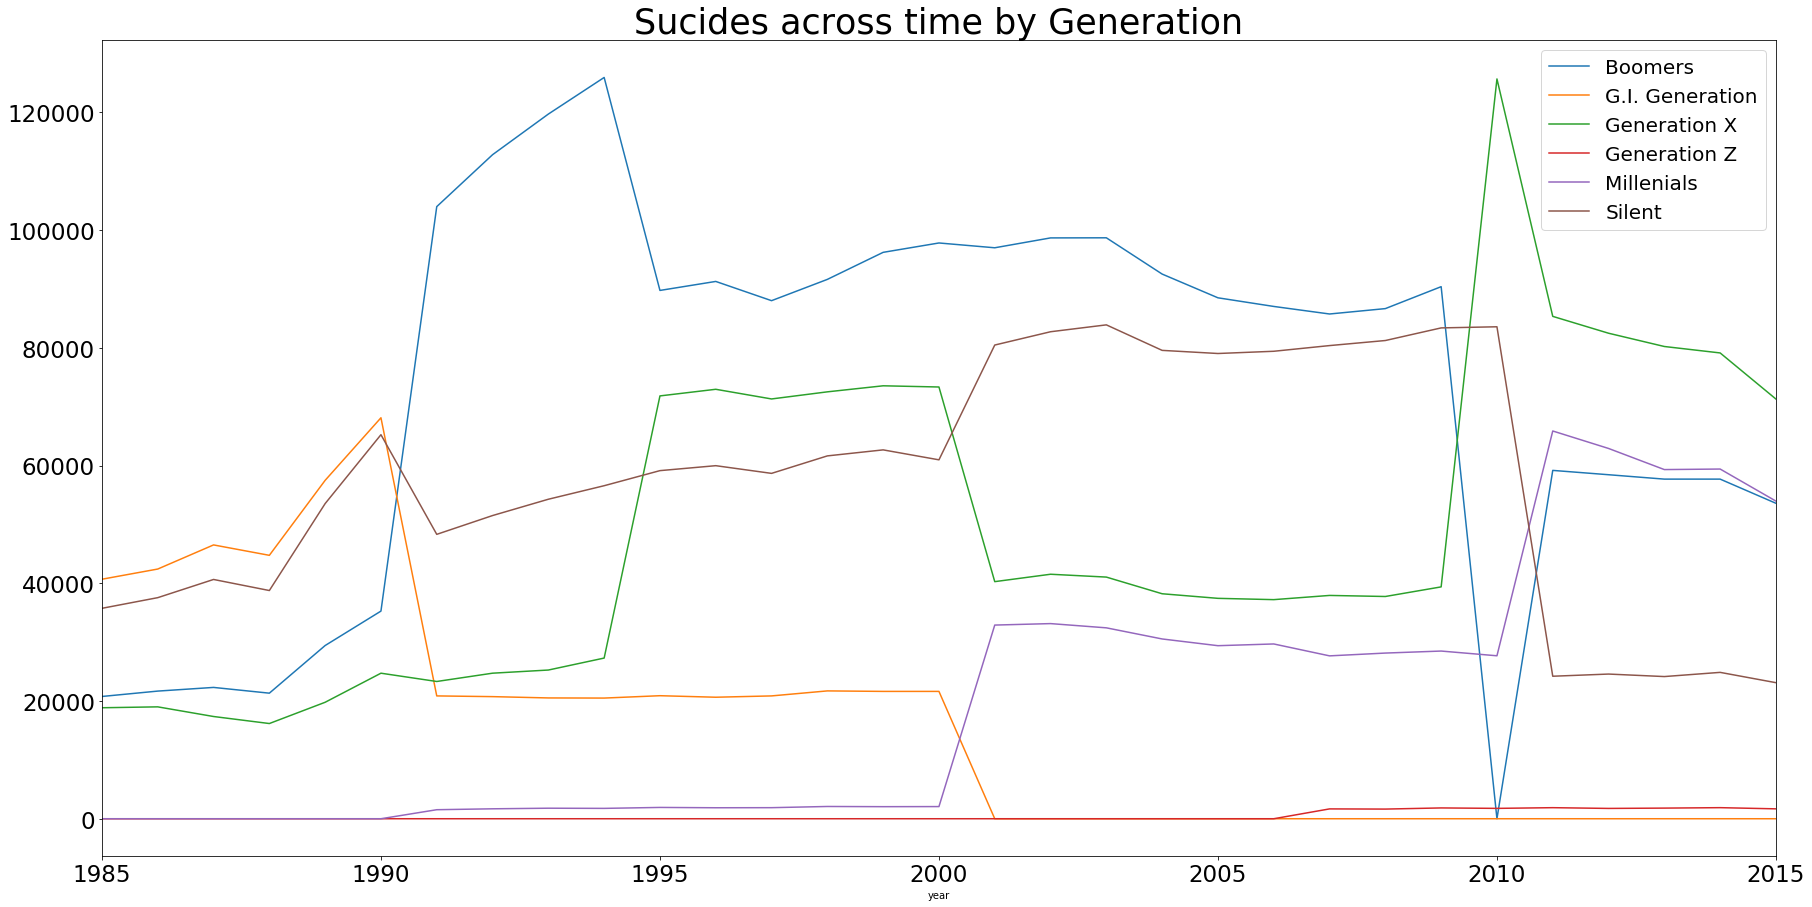

In [876]:
generation_pivot.plot(figsize = (30,15), fontsize=23)
plt.title(label= "Sucides across time by Generation", fontsize=35)
plt.legend(fontsize=20)

In [868]:
# creating pivot for gender across years
gender_pivot = clean_data.pivot_table(index='year', columns='sex', values='suicides_no', aggfunc=np.sum)

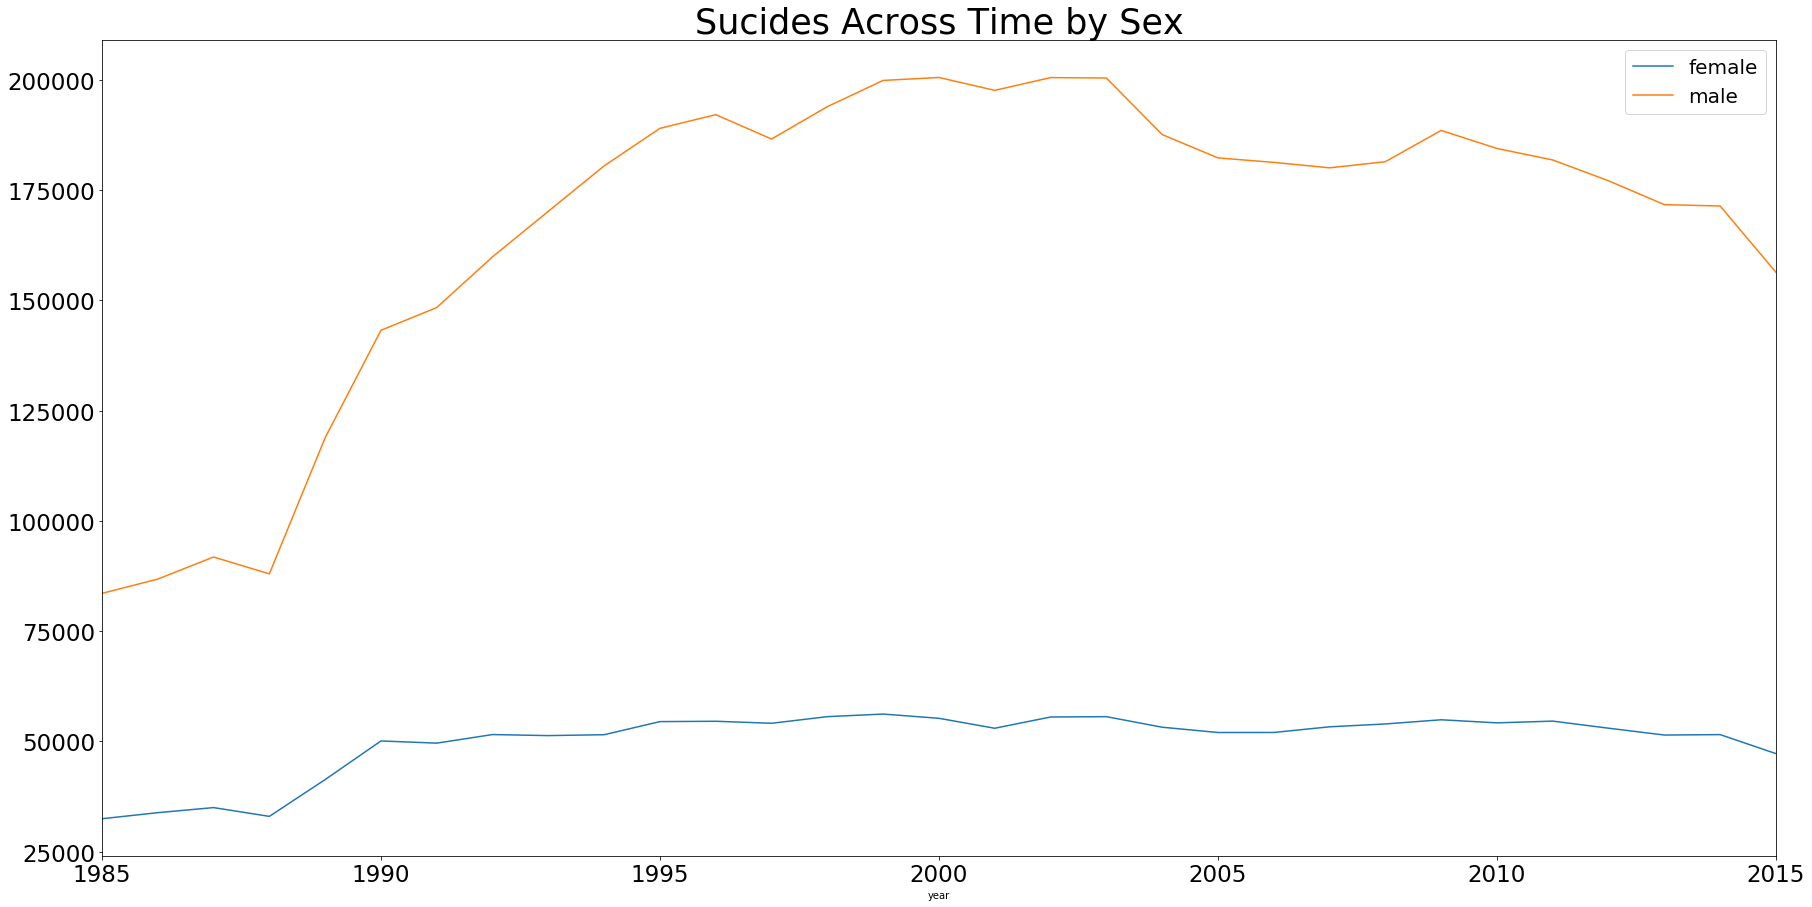

In [875]:
gender_pivot.plot(figsize = (30,15), fontsize=23)
plt.title(label= "Sucides Across Time by Sex", fontsize=35)
plt.legend(fontsize=20)

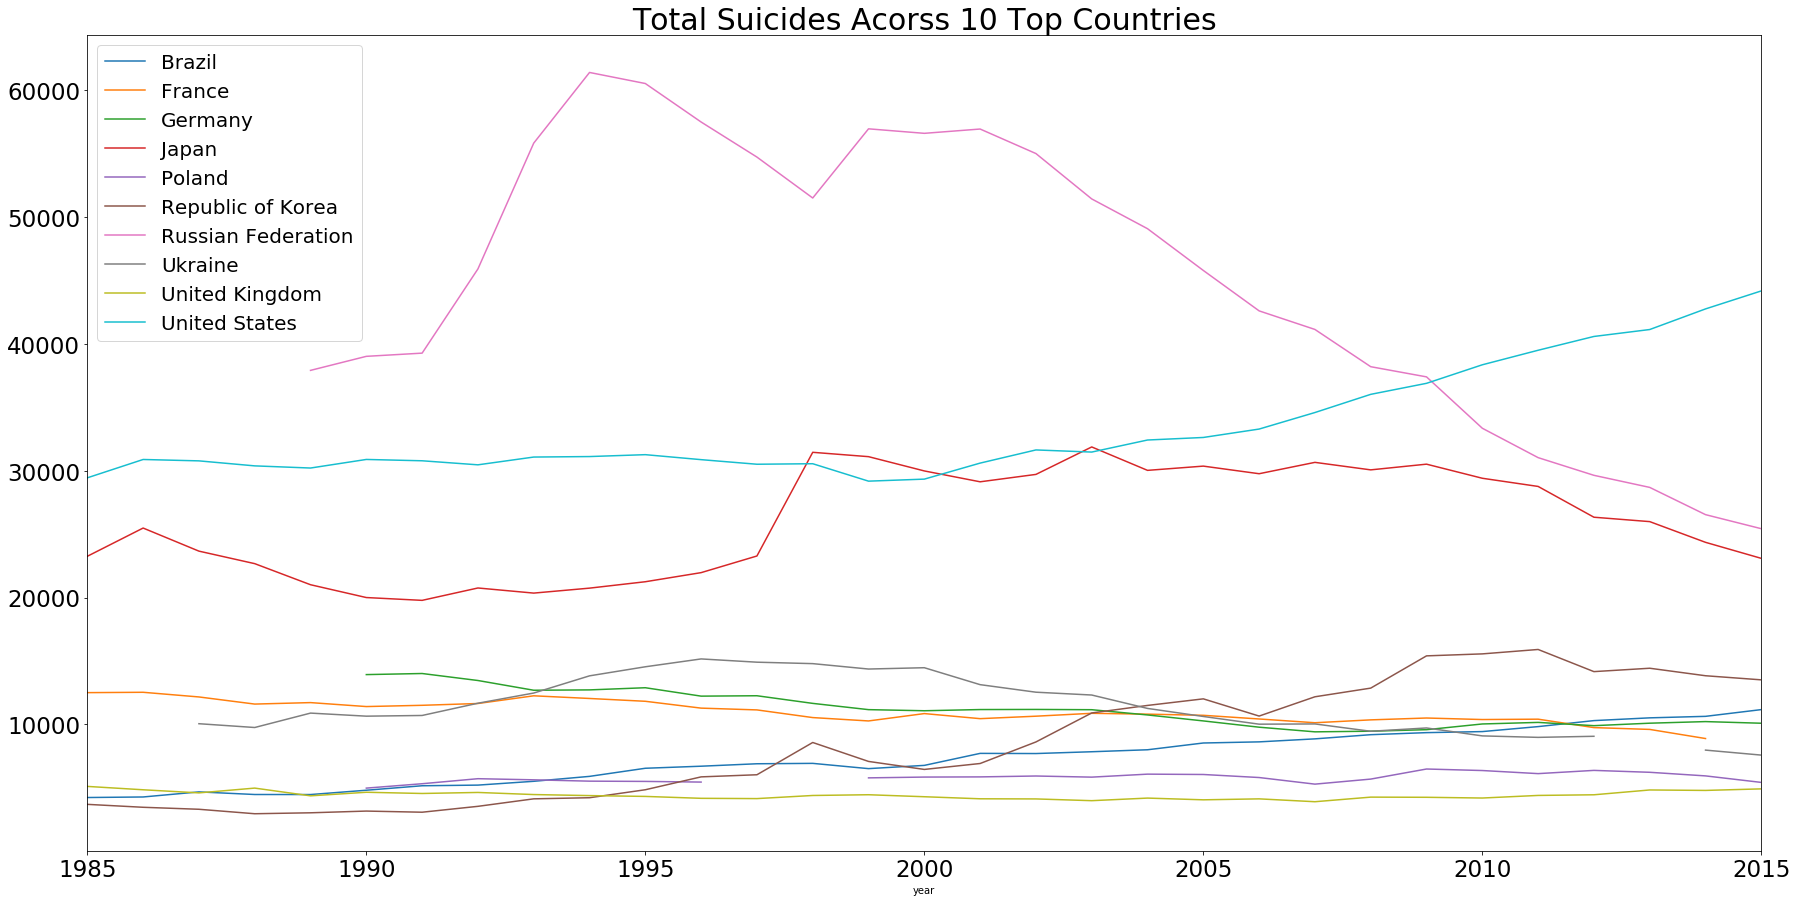

In [883]:
# Suicide Totals in top 10 countries across the years
top_year.fillna(value=0, inplace=True)
top_year = country_year_top10.pivot_table(index='year', columns='country', values='suicides_no')
top_year.plot(figsize = (30,15), fontsize=23)
plt.title('Total Suicides Acorss 10 Top Countries', fontsize=30)
plt.legend(fontsize=20)

In [884]:
# rate per 100K of population
rate_pivot = clean_data.pivot_table(index='year', columns='country', values='suicides/100k pop', aggfunc=np.mean)[top_10]


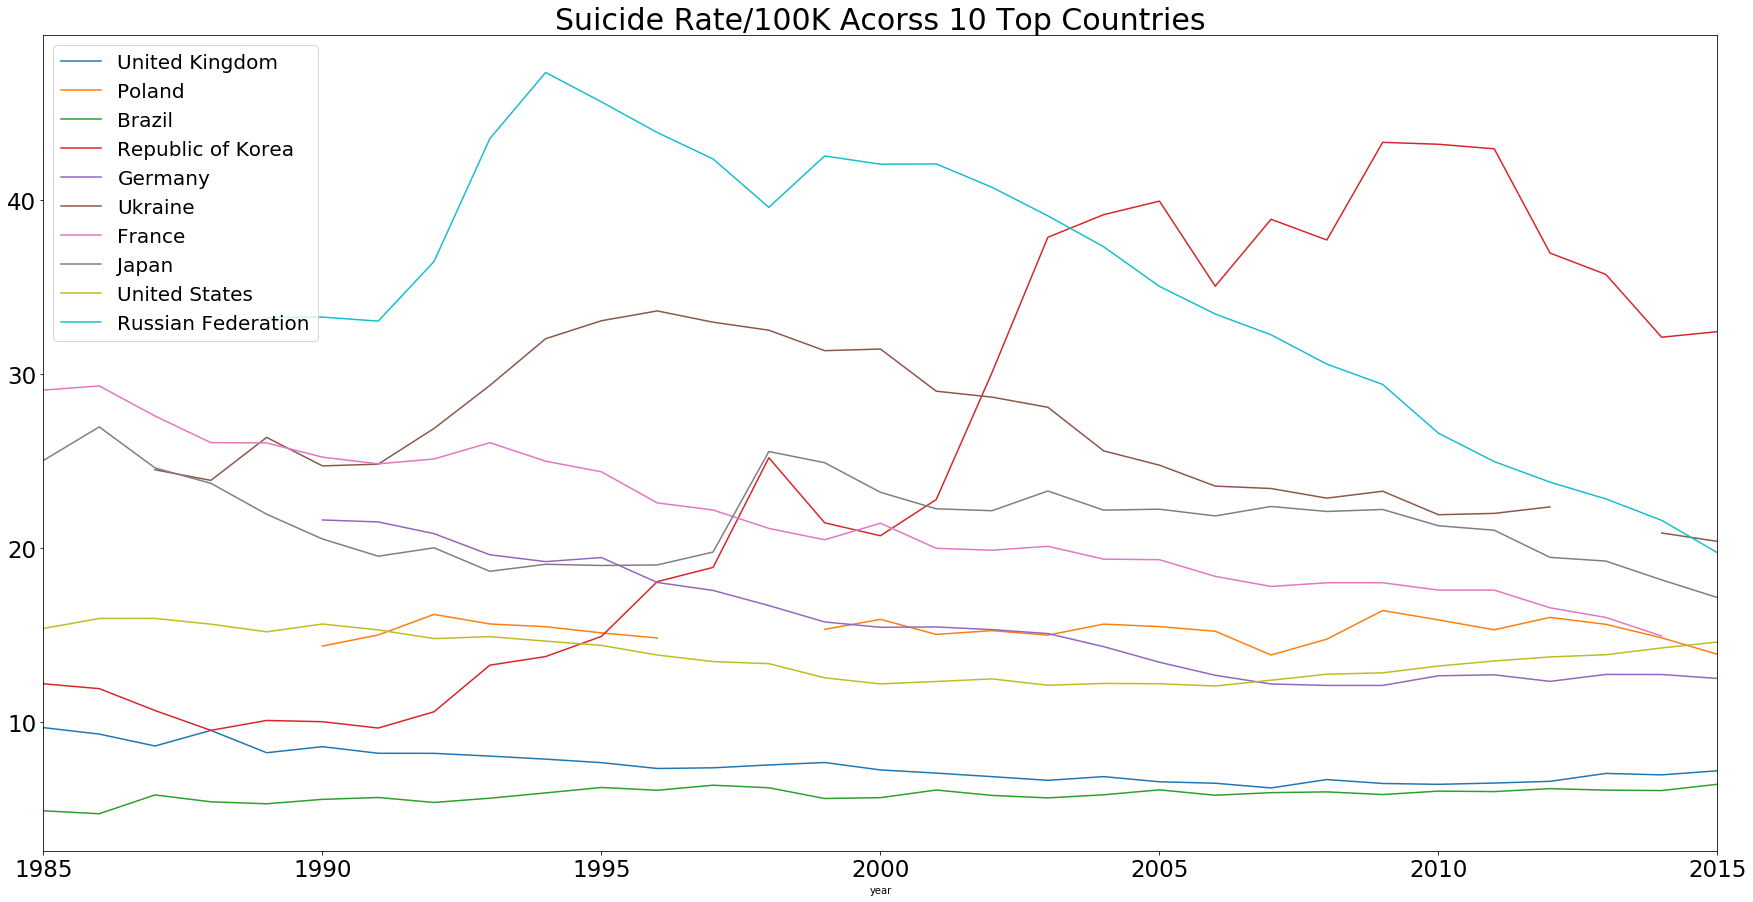

In [888]:
# top 10 countries suicide rate/100k population
rate_pivot.plot(figsize = (30,15), fontsize=23)
plt.title('Suicide Rate/100K Acorss 10 Top Countries', fontsize=30)
plt.legend(fontsize=20)

In [535]:
mean_data = clean_data.groupby('country').mean().drop(columns='year')
mean_data.head()

,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
country,,,,,
Albania,7.462121,2.360813e+05,3.502879,0.673000,1859.045455
Antigua and Barbuda,0.033951,6.142679e+03,0.552901,0.781667,10448.185185
Argentina,221.018817,2.784907e+06,10.469328,0.779600,7914.096774
Armenia,6.381944,2.602366e+05,3.248785,0.690125,1807.458333
Aruba,0.601190,7.498077e+03,9.503095,NaN,24221.642857


/Users/kseniyahusak/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kseniyahusak/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


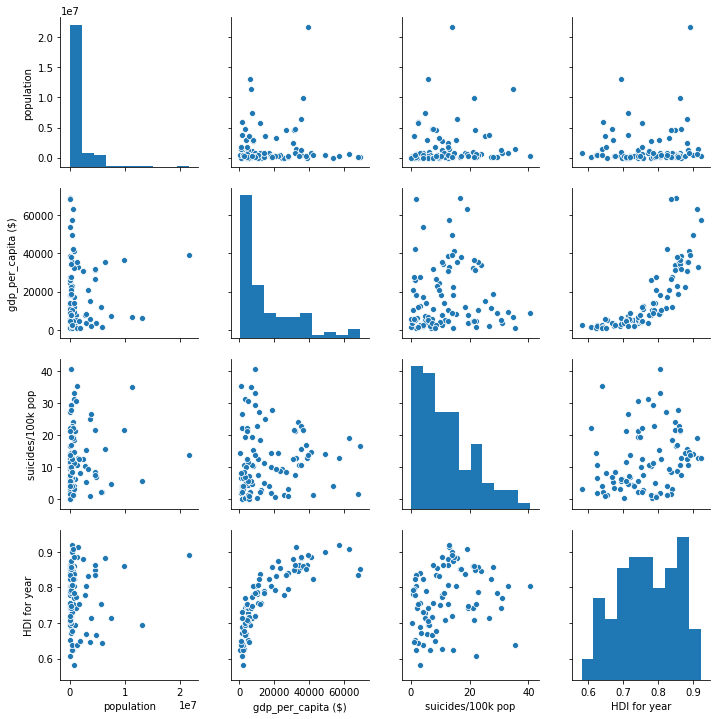

In [578]:
sns.pairplot(mean_data,vars=['population','gdp_per_capita ($)', 'suicides/100k pop', 'HDI for year'])

/Users/kseniyahusak/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kseniyahusak/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


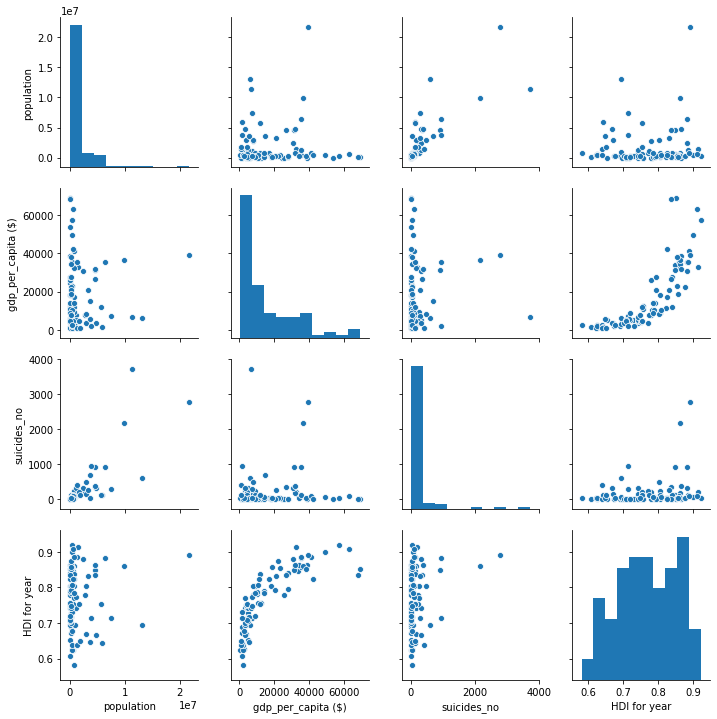

In [890]:
sns.pairplot(mean_data,vars=['population','gdp_per_capita ($)', 'suicides_no', 'HDI for year'])

**Q3**
Is there a statistically significant relationship between suicide rates and economic prosperity? 
To answer this question, I will run an OLS regression to test for a correlation between economic variables (i.e. gdp per capita ) and suicide rates. The challenge of this question is to figure out how to group my data. In terms of the model, I would like to control for other than economic variables as well (gender, perhaps country type?).  

In [537]:
mean_data

,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
country,,,,,
Albania,7.462121,2.360813e+05,3.502879,0.673000,1859.045455
Antigua and Barbuda,0.033951,6.142679e+03,0.552901,0.781667,10448.185185
Argentina,221.018817,2.784907e+06,10.469328,0.779600,7914.096774
Armenia,6.381944,2.602366e+05,3.248785,0.690125,1807.458333
Aruba,0.601190,7.498077e+03,9.503095,NaN,24221.642857
...,...,...,...,...,...
United Arab Emirates,8.638889,5.069760e+05,1.317917,0.825000,42162.000000
United Kingdom,367.755376,4.674107e+06,7.502473,0.863500,31908.354839
United States,2779.604839,2.165061e+07,13.819812,0.891600,39269.612903


In [538]:
# OLS on GDP
model1 = sm.OLS(mean_data['suicides/100k pop'],mean_data['gdp_per_capita ($)']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      suicides/100k pop   R-squared (uncentered):                   0.326
Model:                            OLS   Adj. R-squared (uncentered):              0.319
Method:                 Least Squares   F-statistic:                              47.87
Date:                Thu, 16 Apr 2020   Prob (F-statistic):                    4.55e-10
Time:                        15:01:36   Log-Likelihood:                         -394.13
No. Observations:                 100   AIC:                                      790.3
Df Residuals:                      99   BIC:                                      792.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
gdp_per_capita ($)     0.0004   5.48e-05      6.919      0.000       0.000       0.000
==============================================================================
Omnibus:                        8.627   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.404
Skew:                           0.611   Prob(JB):                       0.0150
Kurtosis:                       3.723   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1030]:
# After dropping all NaNs, 
mean_no_na = mean_data.dropna()
model1 = sm.OLS(mean_no_na['suicides/100k pop'],mean_no_na['HDI for year']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      suicides/100k pop   R-squared (uncentered):                   0.650
Model:                            OLS   Adj. R-squared (uncentered):              0.646
Method:                 Least Squares   F-statistic:                              165.4
Date:                Fri, 17 Apr 2020   Prob (F-statistic):                    5.24e-22
Time:                        18:50:45   Log-Likelihood:                         -324.92
No. Observations:                  90   AIC:                                      651.8
Df Residuals:                      89   BIC:                                      654.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
HDI for year    15.7923      1.228     12.861      0.000      13.352      18.232
==============================================================================
Omnibus:                       14.274   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.831
Skew:                           0.998   Prob(JB):                     0.000365
Kurtosis:                       3.490   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [540]:
x = mean_no_na[['gdp_per_capita ($)','HDI for year']]
model1 = sm.OLS(mean_no_na['suicides/100k pop'],x).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      suicides/100k pop   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.644
Method:                 Least Squares   F-statistic:                              82.52
Date:                Thu, 16 Apr 2020   Prob (F-statistic):                    6.55e-21
Time:                        15:02:05   Log-Likelihood:                         -324.65
No. Observations:                  90   AIC:                                      653.3
Df Residuals:                      88   BIC:                                      658.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
gdp_per_capita ($) -4.602e-05   6.33e-05     -0.727      0.469      -0.000    7.98e-05
HDI for year          16.8348      1.890      8.909      0.000      13.079      20.590
==============================================================================
Omnibus:                       12.595   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.721
Skew:                           0.944   Prob(JB):                      0.00105
Kurtosis:                       3.308   Cond. No.                     4.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Q4**In this question, I am trying to find out if there is a common pattern to suicide victims (i.e. are majority of them men of a certain age regardless of country or does each country differ from one another). Based on my search of existing kernels, clustering would be somewhat useful in understanding if there is a set of characteristics besides country that is common to clusters of people who've committed suicide. Use clustering to examine similar attributes across countries? 

In [1014]:
clean_data.shape


(27660, 11)

In [1031]:
clean_data = clean_data.drop(columns=['HDI for year','country-year'])

In [1032]:
clean_data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers


In [1033]:
# converting to dummies the sex variable
clean_data['sex_male'] = clean_data.sex.map({'female':0, 'male':1})
clean_data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation,sex_male
0,Albania,1987,male,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X,1
1,Albania,1987,male,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent,1
2,Albania,1987,female,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation,1
4,Albania,1987,male,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers,1


In [1034]:
# converting age/generation to dummies
data_dummies = pd.get_dummies(clean_data, columns = ['generation','age'])
data_dummies.head()

,country,year,sex,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),sex_male,generation_Boomers,...,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent,age_15-24 years,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years
0,Albania,1987,male,21,312900,6.71,"2,156,624,900",796,1,0,...,1,0,0,0,1,0,0,0,0,0
1,Albania,1987,male,16,308000,5.19,"2,156,624,900",796,1,0,...,0,0,0,1,0,0,1,0,0,0
2,Albania,1987,female,14,289700,4.83,"2,156,624,900",796,0,0,...,1,0,0,0,1,0,0,0,0,0
3,Albania,1987,male,1,21800,4.59,"2,156,624,900",796,1,0,...,0,0,0,0,0,0,0,0,0,1
4,Albania,1987,male,9,274300,3.28,"2,156,624,900",796,1,1,...,0,0,0,0,0,1,0,0,0,0


In [1035]:
data_dummies.drop(columns='sex', inplace=True)

In [1036]:
# setting index to 'country'
data_indexed_country = data_dummies.set_index('country')
data_indexed_country.head()

,year,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),sex_male,generation_Boomers,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent,age_15-24 years,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years
country,,,,,,,,,,,,,,,,,,,
Albania,1987,21,312900,6.71,"2,156,624,900",796,1,0,0,1,0,0,0,1,0,0,0,0,0
Albania,1987,16,308000,5.19,"2,156,624,900",796,1,0,0,0,0,0,1,0,0,1,0,0,0
Albania,1987,14,289700,4.83,"2,156,624,900",796,0,0,0,1,0,0,0,1,0,0,0,0,0
Albania,1987,1,21800,4.59,"2,156,624,900",796,1,0,1,0,0,0,0,0,0,0,0,0,1
Albania,1987,9,274300,3.28,"2,156,624,900",796,1,1,0,0,0,0,0,0,1,0,0,0,0


In [1037]:
# generating nominal values for each sex/generation dummies 
data_indexed_country['25-34 years'] = data_indexed_country['suicides_no']*data_indexed_country['age_25-34 years']
data_indexed_country['35-54 years'] = data_indexed_country['suicides_no']*data_indexed_country['age_35-54 years']
data_indexed_country['5-14 years'] = data_indexed_country['suicides_no']*data_indexed_country['age_5-14 years']
data_indexed_country['55-74 years'] = data_indexed_country['suicides_no']*data_indexed_country['age_55-74 years']
data_indexed_country['25-34 years'] = data_indexed_country['suicides_no']*data_indexed_country['age_25-34 years']
data_indexed_country['75+ years'] = data_indexed_country['suicides_no']*data_indexed_country['age_75+ years']
data_indexed_country['male'] = data_indexed_country['suicides_no']*data_indexed_country['sex_male']
data_indexed_country['female'] = data_indexed_country['suicides_no'] - data_indexed_country['male']
data_indexed_country['G.I.'] = data_indexed_country['suicides_no']*data_indexed_country['generation_G.I. Generation']
data_indexed_country['Boomers'] = data_indexed_country['suicides_no']*data_indexed_country['generation_Boomers']
data_indexed_country['X'] = data_indexed_country['suicides_no']*data_indexed_country['generation_Generation X']
data_indexed_country['Z'] = data_indexed_country['suicides_no']*data_indexed_country['generation_Generation Z']
data_indexed_country['Millenials'] = data_indexed_country['suicides_no']*data_indexed_country['generation_Millenials']
data_indexed_country['Silent'] = data_indexed_country['suicides_no']*data_indexed_country['generation_Silent']
data_indexed_country.head()

,year,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),sex_male,generation_Boomers,generation_G.I. Generation,generation_Generation X,...,55-74 years,75+ years,male,female,G.I.,Boomers,X,Z,Millenials,Silent
country,,,,,,,,,,,,,,,,,,,,,
Albania,1987,21,312900,6.71,"2,156,624,900",796,1,0,0,1,...,0,0,21,0,0,0,21,0,0,0
Albania,1987,16,308000,5.19,"2,156,624,900",796,1,0,0,0,...,0,0,16,0,0,0,0,0,0,16
Albania,1987,14,289700,4.83,"2,156,624,900",796,0,0,0,1,...,0,0,0,14,0,0,14,0,0,0
Albania,1987,1,21800,4.59,"2,156,624,900",796,1,0,1,0,...,0,1,1,0,1,0,0,0,0,0
Albania,1987,9,274300,3.28,"2,156,624,900",796,1,1,0,0,...,0,0,9,0,0,9,0,0,0,0


In [1040]:
# dropping unnecessary columns and checking the index
data_indexed_country.drop(columns=['age_25-34 years','age_35-54 years','age_5-14 years', 'age_55-74 years','25-34 years',
                                  'sex_male', 'generation_G.I. Generation','generation_Generation X',
                                  'generation_Generation Z', 'generation_Millenials', 'generation_Silent',
                                  'generation_Boomers'], inplace=True)
data_indexed_country.columns

Index(['year', 'suicides_no', 'population', 'suicides/100k pop',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'age_15-24 years',
       'age_75+ years', '35-54 years', '5-14 years', '55-74 years',
       '75+ years', 'male', 'female', 'G.I.', 'Boomers', 'X', 'Z',
       'Millenials', 'Silent'],
      dtype='object')

In [1041]:
data_indexed_country.reset_index(inplace=True)

In [1042]:
# widening the data 

# grouping to analyze how complete the dataset is 
agg_dict = {'country':'nunique',
            'population':'sum',
            'suicides_no':'sum',
            'suicides/100k pop':'mean',
            'gdp_per_capita ($)':"mean",
           '35-54 years':'sum', 
            '5-14 years': "sum", 
            '55-74 years':"sum", 
            '75+ years':'sum',
            'male':"sum", 
            'female':"sum", 
            'G.I.':"sum",
       'X':"sum", 'Z':"sum", 'Millenials':"sum", 'Silent':"sum", 'Boomers': 'sum'}


grouped = data_indexed_country[['year', 'country', 'population','suicides_no',
                                 'suicides/100k pop', 'gdp_per_capita ($)', 
                                '75+ years','35-54 years', '5-14 years', '55-74 years',
                                'male', 'female', 'G.I.','X', 'Z', 'Millenials', 
                                'Silent', 'Boomers']].groupby('country').agg(agg_dict)
grouped.head()

,country,population,suicides_no,suicides/100k pop,gdp_per_capita ($),35-54 years,5-14 years,55-74 years,75+ years,male,female,G.I.,X,Z,Millenials,Silent,Boomers
country,,,,,,,,,,,,,,,,,
Albania,1,62325467,1970,3.502879,1859.045455,591,61,264,81,1277,693,52,736,14,236,355,577
Antigua and Barbuda,1,1990228,11,0.552901,10448.185185,6,0,4,0,10,1,0,0,0,0,4,7
Argentina,1,1035985431,82219,10.469328,7914.096774,21781,1452,19862,7979,63893,18326,8514,17609,548,16086,20507,18955
Armenia,1,74948140,1838,3.248785,1807.458333,630,24,552,179,1357,481,78,360,10,146,605,639
Aruba,1,1259677,101,9.503095,24221.642857,42,0,22,6,84,17,5,32,0,6,19,39


In [1043]:
grouped.shape

(100, 17)

In [1044]:
# I am using three clusters with Euclidian distance
model = AgglomerativeClustering(n_clusters=3)
model.fit_predict(grouped)

array([2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2])

In [1045]:
#populating labels from predicted clusters 
grouped['cluster'] = model.labels_
grouped.sample(5)

,country,population,suicides_no,suicides/100k pop,gdp_per_capita ($),35-54 years,5-14 years,55-74 years,75+ years,male,female,G.I.,X,Z,Millenials,Silent,Boomers,cluster
country,,,,,,,,,,,,,,,,,,
Belize,1,6289015,348,6.230625,4006.464286,104,12,33,9,297,51,5,119,6,112,26,80,2
Ireland,1,109023686,12574,10.782583,34230.866667,4498,86,2372,358,10123,2451,658,3983,29,1736,2170,3998,2
Cuba,1,251790133,41418,21.222049,4351.166667,13570,185,11741,6573,29743,11675,2724,9474,59,1972,13184,14005,2
Serbia,1,126140138,24179,22.164120,4471.277778,6947,41,9230,4874,17416,6763,763,3720,8,1336,11119,7233,2
Bulgaria,1,231939958,36388,19.489111,3640.433333,10049,301,12734,7439,26420,9968,7561,4686,16,1201,13719,9205,2


In [1046]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

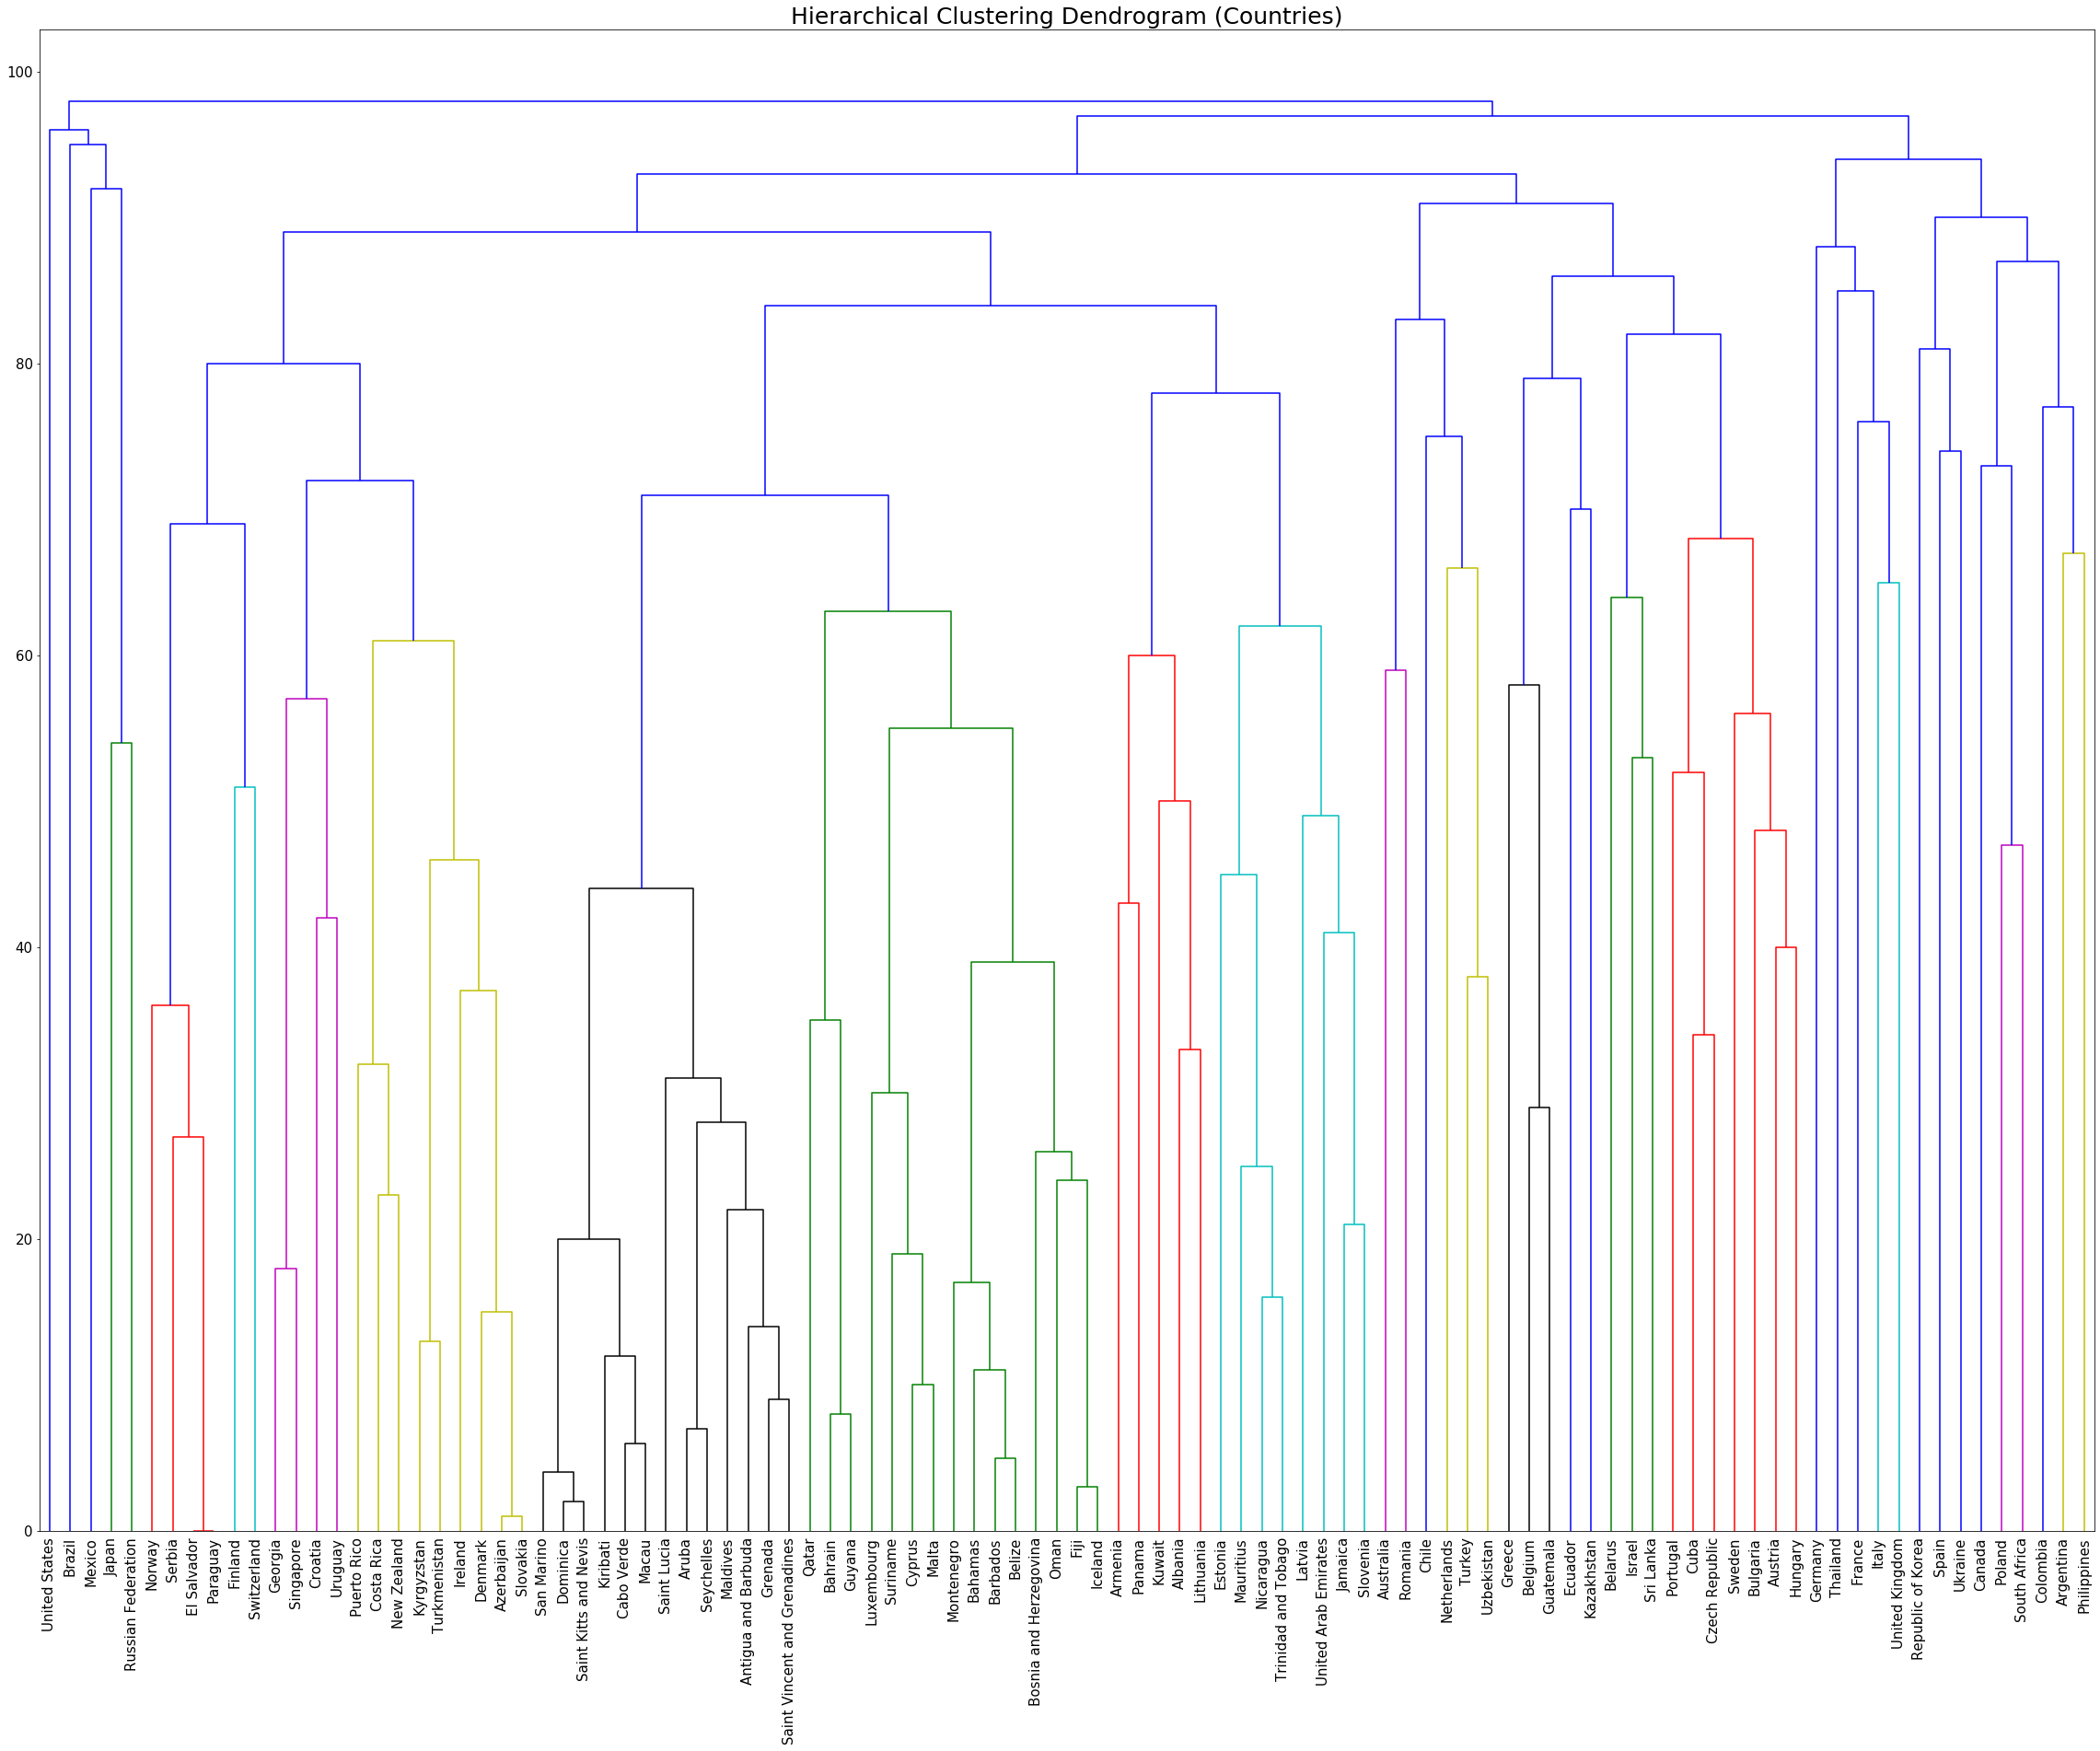

In [1047]:
plt.figure(figsize=(40,30))
plt.title('Hierarchical Clustering Dendrogram (Countries)', fontsize=25)
plot_dendrogram(model,labels=grouped.index.values)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('suicides.pdf',format='pdf') 
plt.show()

In [1048]:
# looking at characteristics of clusters 
grouped.groupby('cluster').describe().stack()

country    population   suicides_no  suicides/100k pop  \
cluster                                                                 
0       count      5.0  5.000000e+00  5.000000e+00           5.000000   
        mean       1.0  4.610981e+09  6.776818e+05          16.167782   
        std        0.0  2.061827e+09  4.876453e+05          12.482175   
        min        1.0  2.772959e+09  1.111390e+05           4.707500   
        25%        1.0  3.681025e+09  2.266130e+05           5.846022   
        50%        1.0  3.690803e+09  8.069020e+05          13.819812   
        75%        1.0  4.856094e+09  1.034013e+06          21.573199   
        max        1.0  8.054027e+09  1.209742e+06          34.892377   
1       count     14.0  1.400000e+01  1.400000e+01          14.000000   
        mean       1.0  1.308874e+09  1.491622e+05          12.032487   
        std        0.0  3.767645e+08  1.078050e+05           7.967218   
        min        1.0  8.260522e+08  7.321000e+03           0.964542   
        25%        1.0  1.043256e+09  8.671475e+04           7.165780   
        50%        1.0  1.257065e+09  1.198105e+05           9.951142   
        75%        1.0  1.635907e+09  2.310720e+05          15.487306   
        max        1.0  2.024876e+09  3.291270e+05          26.582321   
2       count     81.0  8.100000e+01  8.100000e+01          81.000000   
        mean       1.0  1.211224e+08  1.550786e+04          11.698874   
        std        0.0  1.430245e+08  2.169229e+04           9.457461   
        min        1.0  6.640000e+04  0.000000e+00           0.000000   
        25%        1.0  8.987087e+06  3.760000e+02           4.064839   
        50%        1.0  7.494814e+07  6.792000e+03          10.186237   
        75%        1.0  1.730718e+08  2.066000e+04          17.045645   
        max        1.0  5.584211e+08  1.015460e+05          40.583968   

               gdp_per_capita ($)    35-54 years   5-14 years    55-74 years  \
cluster                                                                        
0       count            5.000000       5.000000     5.000000       5.000000   
        mean         19083.182318  249718.600000  5370.400000  163020.400000   
        std          17150.826533  192233.860967  3267.881164  127735.244856   
        min           6091.483871   29997.000000  2130.000000   12318.000000   
        25%           6518.814815   79860.000000  3029.000000   37556.000000   
        50%           7138.451613  278679.000000  3930.000000  224770.000000   
        75%          36397.548387  380917.000000  8840.000000  267753.000000   
        max          39269.612903  479140.000000  8923.000000  272705.000000   
1       count           14.000000      14.000000    14.000000      14.000000   
        mean         16004.965416   53520.142857   923.428571   38507.928571   
        std          12927.371335   41603.992924   577.393975   32365.801388   
        min           1540.200000    2102.000000   163.000000     691.000000   
        25%           4179.100806   23918.500000   423.250000   16733.000000   
        50%          11473.858199   41632.000000   863.000000   29944.500000   
        75%          29816.257230   87234.250000  1332.000000   62259.000000   
        max          35164.230769  124721.000000  1949.000000   90385.000000   
2       count           81.000000      81.000000    81.000000      81.000000   
        mean         15833.078771    5537.037037   154.123457    3697.716049   
        std          17041.678365    8222.243586   300.889157    5389.539014   
        min            720.730769       0.000000     0.000000       0.000000   
        25%           4006.464286     137.000000     4.000000      34.000000   
        50%           8961.095238    1944.000000    61.000000     765.000000   
        75%          23125.451613    6085.000000   146.000000    4683.000000   
        max          68798.387097   37598.000000  1911.000000   22033.000000   

                   75+ years       

In [1049]:
stats_cluster = grouped.groupby('cluster').mean()
stats_cluster.drop(columns='country', inplace=True)


In [1050]:
table = pd.DataFrame(stats_cluster.stack())


In [1051]:
cluster_1 = pd.DataFrame(stats_cluster.iloc[0])
cluster_1

,0
population,4.610981e+09
suicides_no,6.776818e+05
suicides/100k pop,1.616778e+01
gdp_per_capita ($),1.908318e+04
35-54 years,2.497186e+05
5-14 years,5.370400e+03
55-74 years,1.630204e+05
75+ years,5.790000e+04
male,5.280606e+05
female,1.496212e+05


In [1052]:
cluster_2 = pd.DataFrame(stats_cluster.iloc[1])
cluster_2

,1
population,1.308874e+09
suicides_no,1.491622e+05
suicides/100k pop,1.203249e+01
gdp_per_capita ($),1.600497e+04
35-54 years,5.352014e+04
5-14 years,9.234286e+02
55-74 years,3.850793e+04
75+ years,1.733814e+04
male,1.125619e+05
female,3.660036e+04


In [1053]:
cluster_3 = pd.DataFrame(stats_cluster.iloc[2])
cluster_3

,2
population,1.211224e+08
suicides_no,1.550786e+04
suicides/100k pop,1.169887e+01
gdp_per_capita ($),1.583308e+04
35-54 years,5.537037e+03
5-14 years,1.541235e+02
55-74 years,3.697716e+03
75+ years,1.469469e+03
male,1.185978e+04
female,3.648086e+03


In [1055]:
final_table = pd.concat([cluster_1, cluster_2, cluster_3],axis=1)

In [1056]:
final_table.columns = ['Cluster_1', 'Cluster_2', 'Cluster_3']

In [1057]:
final_table

,Cluster_1,Cluster_2,Cluster_3
population,4.610981e+09,1.308874e+09,1.211224e+08
suicides_no,6.776818e+05,1.491622e+05,1.550786e+04
suicides/100k pop,1.616778e+01,1.203249e+01,1.169887e+01
gdp_per_capita ($),1.908318e+04,1.600497e+04,1.583308e+04
35-54 years,2.497186e+05,5.352014e+04,5.537037e+03
5-14 years,5.370400e+03,9.234286e+02,1.541235e+02
55-74 years,1.630204e+05,3.850793e+04,3.697716e+03
75+ years,5.790000e+04,1.733814e+04,1.469469e+03
male,5.280606e+05,1.125619e+05,1.185978e+04
female,1.496212e+05,3.660036e+04,3.648086e+03


In [1058]:
grouped.query('cluster == 1')

,country,population,suicides_no,suicides/100k pop,gdp_per_capita ($),35-54 years,5-14 years,55-74 years,75+ years,male,female,G.I.,X,Z,Millenials,Silent,Boomers,cluster
country,,,,,,,,,,,,,,,,,,
Argentina,1,1035985431,82219,10.469328,7914.096774,21781,1452,19862,7979,63893,18326,8514,17609,548,16086,20507,18955,1
Canada,1,826052183,107561,12.467586,30887.482759,44014,979,20848,5814,83377,24184,6870,26063,215,8555,23700,42158,1
Colombia,1,1107941966,53080,5.401586,3708.967742,12990,1866,6232,1581,41737,11343,1093,18389,709,14051,6335,12503,1
France,1,1670756775,329127,21.675694,31481.466667,123510,877,86509,55872,239708,89419,50767,52831,249,11291,103816,110173,1
Germany,1,2024875612,291262,15.559904,35164.230769,97833,832,89191,52557,211555,79707,27249,47356,196,14094,102683,99684,1
Italy,1,1715043704,132060,8.518468,26602.580645,39250,400,43314,24410,99179,32881,22613,22836,83,5270,45913,35345,1
Philippines,1,1065068179,21330,2.421278,1540.200000,5716,493,2168,488,16057,5273,121,7505,243,6144,2269,5048,1
Poland,1,866180029,139098,15.269514,8146.458333,60061,849,35758,6938,118035,21063,3220,30654,205,14609,31812,58598,1
Republic of Korea,1,1354944936,261730,25.135618,14801.258065,96292,1428,68574,28026,179115,82615,6518,71059,449,21796,75321,86587,1


In [1059]:
grouped.query('cluster == 0')

,country,population,suicides_no,suicides/100k pop,gdp_per_capita ($),35-54 years,5-14 years,55-74 years,75+ years,male,female,G.I.,X,Z,Millenials,Silent,Boomers,cluster
country,,,,,,,,,,,,,,,,,,
Brazil,1,4856093548,226613,5.846022,6091.483871,79860,3029,37556,9037,177598,49015,7811,70971,1073,38753,37641,70364,0
Japan,1,3681024844,806902,21.573199,36397.548387,278679,2130,272705,106571,555272,251630,90657,133292,657,42991,297885,241420,0
Mexico,1,2772959159,111139,4.707500,7138.451613,29997,3930,12318,4004,91805,19334,2772,38546,1779,29628,12948,25466,0
Russian Federation,1,3690802620,1209742,34.892377,6518.814815,479140,8840,267753,74211,995412,214330,51699,275309,1720,119618,290471,470925,0
United States,1,8054027201,1034013,13.819812,39269.612903,380917,8923,224770,95677,820216,213797,89865,253704,2779,104032,228971,354662,0


In [1060]:
grouped.query('cluster == 2')

,country,population,suicides_no,suicides/100k pop,gdp_per_capita ($),35-54 years,5-14 years,55-74 years,75+ years,male,female,G.I.,X,Z,Millenials,Silent,Boomers,cluster
country,,,,,,,,,,,,,,,,,,
Albania,1,62325467,1970,3.502879,1859.045455,591,61,264,81,1277,693,52,736,14,236,355,577,2
Antigua and Barbuda,1,1990228,11,0.552901,10448.185185,6,0,4,0,10,1,0,0,0,0,4,7,2
Armenia,1,74948140,1838,3.248785,1807.458333,630,24,552,179,1357,481,78,360,10,146,605,639,2
Aruba,1,1259677,101,9.503095,24221.642857,42,0,22,6,84,17,5,32,0,6,19,39,2
Australia,1,542377786,70111,12.992806,32776.400000,26150,320,12911,4610,54785,15326,4677,20951,126,6964,13929,23464,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Turkey,1,482640582,10131,2.371071,12134.285714,3304,290,1713,562,7562,2569,0,3501,290,3720,962,1658,2
Turkmenistan,1,115576818,8624,8.605546,2618.103448,2487,240,765,149,6528,2096,271,3134,52,1776,912,2479,2
United Arab Emirates,1,36502275,622,1.317917,42162.000000,235,2,23,1,524,98,0,292,2,104,24,200,2
